In [1]:
import torch
import os
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

CURRENT_DIR = os.path.dirname(os.path.abspath("__file__"))


In [2]:
# Load the pre-trained model
model = maskrcnn_resnet50_fpn(pretrained=True)
model = model.eval()

# Load your image
image = Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'rawimages', "Ganglioneuroblastoma_0.tif")).convert("L")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def predict(img: Image.Image, model) -> torch.Tensor:
    image_tensor = F.to_tensor(img)
    # Add an extra dimension at the beginning of the tensor, which represents the batch size
    image_tensor = image_tensor.unsqueeze(0)

    # Check for GPU availability and if available, move the model and input tensor to GPU
    if torch.cuda.is_available():
        model = model.cuda()
        image_tensor = image_tensor.cuda()

    # Perform inference
    with torch.no_grad():
        prediction = model(image_tensor)
        return prediction

In [6]:
prediction = predict(img=image, model=model)

In [39]:
def plot_prediction(prediction, score_threshold, image):
    pred = prediction[0]

    # The masks are binary masks of shape (N, 1, H, W),
    # where N is the number of predicted masks (i.e., number of instances),
    # H and W are the height and width of the masks
    masks = pred['masks'].cpu().detach().numpy()
    scores = pred['scores'].cpu().detach().numpy()
    boxes = pred['boxes'].cpu().detach().numpy()

    # Create a figure and axes
    fig, ax = plt.subplots(1, figsize=(15, 15))

    # Display the image
    ax.imshow(image)
    
    # For each mask
    all_masks = np.zeros((masks.shape[2], masks.shape[3]))
    for i in range(masks.shape[0]):
        if scores[i] < score_threshold:
            continue
        # Draw the mask
        all_masks += masks[i][0]

        # Draw the bounding box
        box = boxes[i]
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Display the score
        score = scores[i]
        ax.text(box[0], box[1], str(score), fontsize=12, color='r')

    ax.imshow(all_masks, alpha=0.4)
    plt.show()

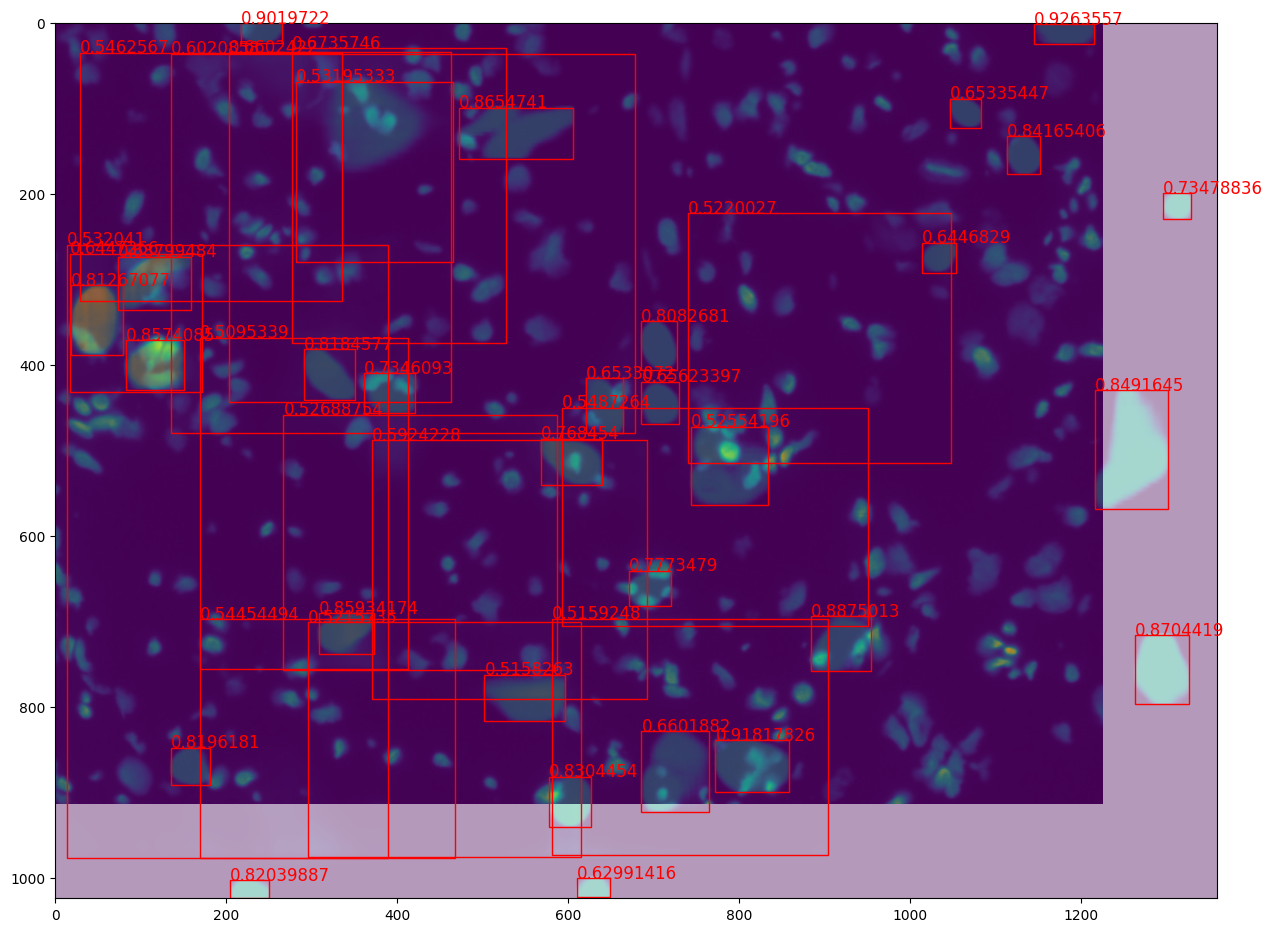

In [40]:
plot_prediction(prediction, score_threshold=0.5, image=image)

## Check pretrained model

In [41]:
from models.maskrcnn import MaskRCNN

In [42]:
model = MaskRCNN.from_pretrained(
    path="../saved_models/maskrcnn_epoch_160.pth",
    gpu=False,
)
model.eval()

In [43]:
X = Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'rawimages', "Ganglioneuroblastoma_10.tif")).convert("L")
y = Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'groundtruth', "Ganglioneuroblastoma_10.tif")).convert("L")

In [44]:
%%time
prediction = predict(img=X, model=model)

CPU times: user 5.45 s, sys: 2.25 s, total: 7.7 s
Wall time: 3.53 s


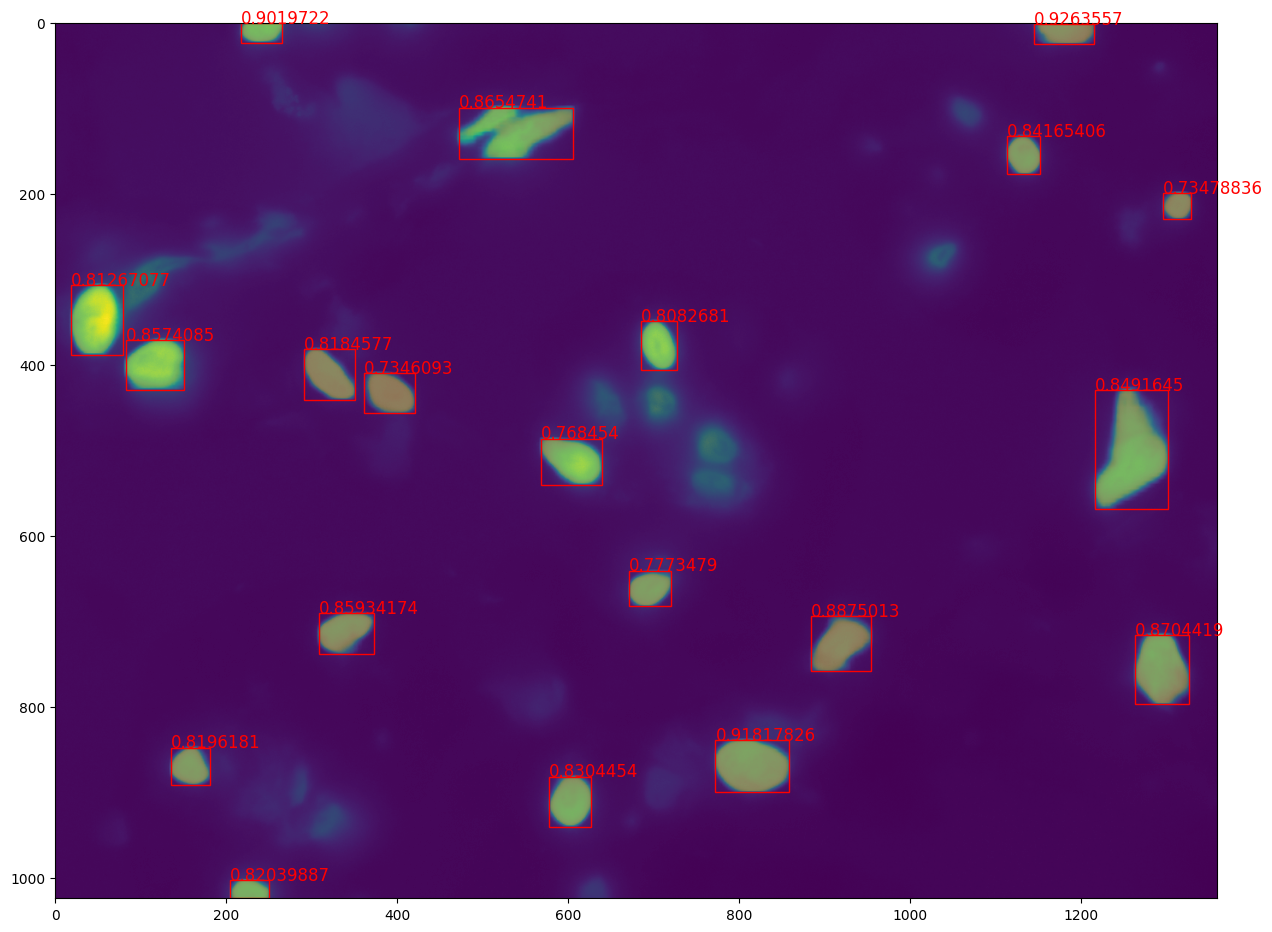

In [47]:
plot_prediction(prediction=prediction, score_threshold=0.7, image=X)

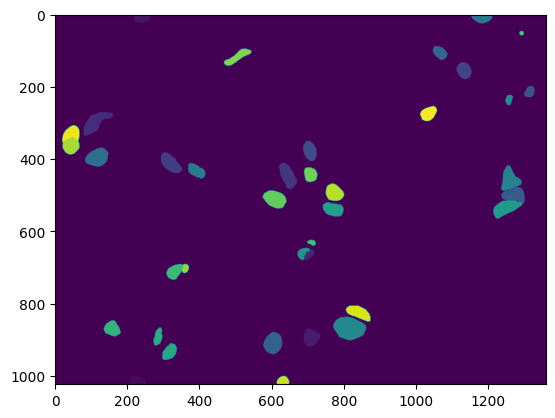

In [48]:
plt.imshow(y)